<a href="https://colab.research.google.com/github/bgalerne/M2MAS_neural_networks/blob/main/M2MAS_BloodMNIST_classification_202122.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet final pour le cours M2MAS "Réseaux de Neurones profonds pour l'Apprentissage", année 2021-2022

Fichier ```NOM_Prenom_M2MAS_BloodMNIST_classification.ipynb``` à envoyer par email à `bruno.galerne@univ-orleans.fr` pour le lundi 7 mars 2022 (demande de délai supplémentaire possible si problème de dispo à cause de votre stage).

Envoi d'un lien à partir d'un cloud (partage renater, dropbox, google drive,...) si la taille du fichier est supérieur à 5 Mo.

# Classification of the BloodMNIST database


*Reference:*
 - [MedMNIST v2](https://medmnist.com/): A Large-Scale Lightweight Benchmark for 2D and 3D Biomedical Image Classification, Jiancheng Yang,Rui Shi,Donglai Wei,Zequan Liu,Lin Zhao,Bilian Ke,Hanspeter Pfister,Bingbing Ni, 2021.
Paper [arXiv](https://arxiv.org/pdf/2110.14795.pdf) Code [GitHub](https://github.com/MedMNIST/MedMNIST)



In [1]:
!pip install medmnist

     |████████████████████████████████| 87 kB 3.3 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115942 sha256=0b856138d02142a260e043ca87ab5300fd5e0309faba529ca55f6d116323ea57
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire


Import necessary libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import medmnist
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

MedMNIST v2.0.2 @ https://github.com/MedMNIST/MedMNIST/
cuda


Downlaod dataset and define dataloaders

In [3]:
info = medmnist.INFO['bloodmnist']

for cell in info:
  print(cell)
  print(info[cell])
  print('\n')



python_class
BloodMNIST


description
The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.


url
https://zenodo.org/record/5208230/files/bloodmnist.npz?download=1


MD5
7053d0359d879ad8a5505303e11de1dc


task
multi-class


label
{'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'ig', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}


n_channels
3


n_samples
{'train': 11959, 'val': 1712, 'test': 3421}


license
CC BY 4.0




In [4]:
BATCH_SIZE = 128

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
DataClass = getattr(medmnist, info['python_class'])
train_dataset = DataClass(split='train', transform=data_transform, download=True)
val_dataset = DataClass(split='val', transform=data_transform, download=True)
test_dataset = DataClass(split='test', transform=data_transform, download=True)

print(train_dataset)
print("===================")
print(test_dataset)
print("===================")
print(val_dataset)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

  0%|          | 0/35461855 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Dataset BloodMNIST (bloodmnist)
    Number of datapoints: 11959
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'ig', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3

Display function ```montage``` provided by MEDMNIST

In [5]:
train_dataset.montage(1)

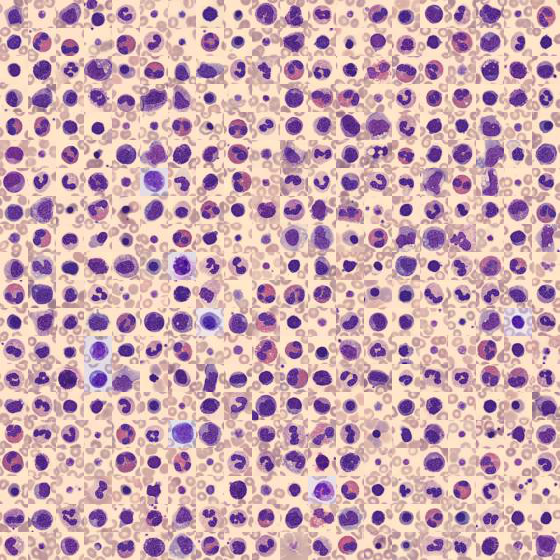

In [6]:
train_dataset.montage(20)

Function to display a list of images (e.g. from a batch) :

Images:


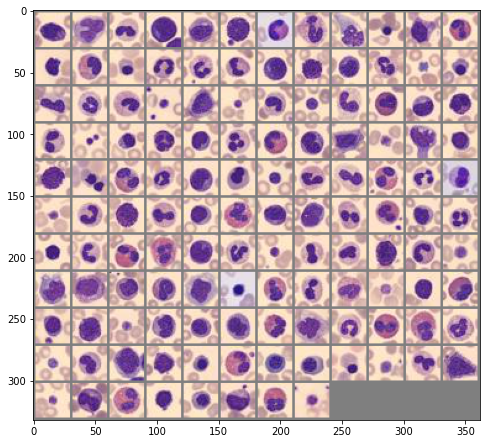

0 basophil


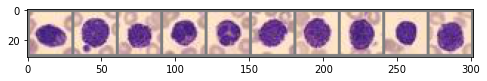

1 eosinophil


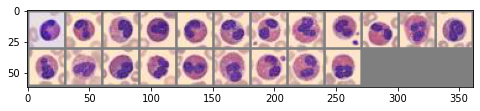

2 erythroblast


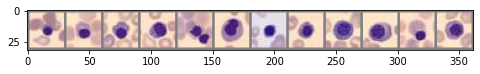

3 ig


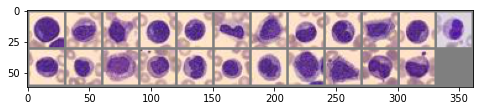

4 lymphocyte


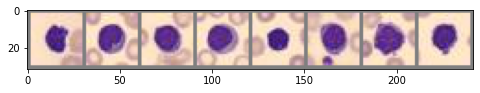

5 monocyte


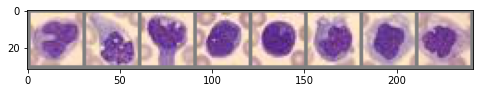

6 neutrophil


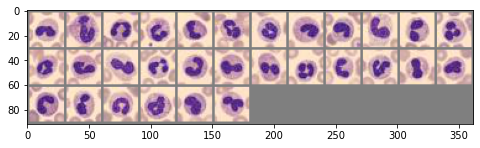

7 platelet


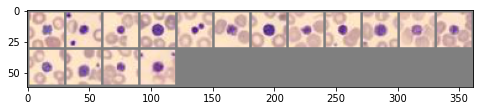

In [42]:
def imshow(img):
    img = img.clone().detach().to('cpu')*0.5 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images:
print('Images:')
imshow(torchvision.utils.make_grid(images, nrow=12))

# show images for each class:
for k in info['label']:
  print(k, info['label'][k])
  # get some random training images
  # show images
  idx = (labels==int(k)).view(-1)
  if idx.numel()>0:
    imshow(torchvision.utils.make_grid(images[idx,:,:,:], nrow=12))


## Question 1: Answer the questions:

  1. What is the size of an image from the dataset ? 

  2. How many images are in each split train/val/test ?

  3. What is the number of classes ?

### Answer: 

1.

2.

3.


# A first neural network for classification:



We will classify the ```BloodMNIST```images using the following CNN architecture.


* CNN part: All 2D convolutions have kernel size 3x3.
  * A 2D convolution with 16 ouput chanels, followed by ReLU.
  * A 2D convolution with 16 ouput chanels, followed by ReLU.
  * A 2D max-pooling with size 2x2
  * A 2D convolution with 64 ouput chanels, followed by ReLU.
  * A 2D convolution with 64 ouput chanels, followed by ReLU.
  * A 2D convolution with 64 ouput chanels, followed by ReLU.
  * A 2D max-pooling with size 2x2 
* Fully connected part:
  * A linear layer with output dimension 128, followed by ReLU.
  * A linear layer with output dimension 128, followed by ReLU.
  * A last linear layer



## Question 2:

For each step of the CNN, precise the size of the batch of the tensor starting from a tensor of size $b \times  c \times h \times w$ where $c \times h \times w$ are the answers of question 1.1.


### Answer:

## Question 3:

1. Define a class ```Net``` that implements in PyTorch the considered architecture for ```BloodMNIST``` classification.

2. Check that the forward function is well-defined by applying it to a batch of the training set.


In [ ]:
# TODO : Define class Net here



In [ ]:
# TODO : Check that the forward function is well-defined by applying it to a batch of the training set.



## Question 4:

The goal of this question is to train a neural network of your class ```model=Net()``` to classify the ```BloodMNIST``` dataset.

Propose a training script that:
 * has 6 epochs
 * uses the optimizer
    ```
    lr = 0.001
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    ```
 * at each epoch, computes the *epoch loss* (that is the mean of the training loss on each batch of the training set) and, and the end of each epoch, compute
the classification accuracy on the validation set.
 * print at the end of the training the time spent for training in minutes and seconds.
 * displays at the end of the training the two plots of running loss VS epochs and accuracy on validation set VS epochs.
 * displays at the end of the training a classification report and a confusion matrix on the validation set using scikit-learn.

In [ ]:
# TODO: training



## Question 5: 

Duplicate your training script below and adpat it so that the training is executed on the GPU. 

Discuss before all the changes that needs to be done. 

Report and discuss the difference of execution times.


### Answer: 

In [ ]:
# TODO: training on GPU:



### Answer: 

## Question 6: 

Re-execute a training on the GPU using 40 epochs (be careful to initialize a new network).

Discuss the performance of the final model.

In [ ]:
# TODO: training on GPU with 40 epochs:



### Answer:

# A second neural network for classification:



## Question 7:

We will now try to improve the architecture by introducing batch normalization layers within the network.

1. Define a new class ```Net_with_BN``` that adds a 2D batchnormalization layer between each 2D-convolution layer and ReLU activation layer (that is after the 2D convolution and before ReLU). 

2. Train a model ```model_with_bn = Net_with_BN()``` (on the GPU with 40 epochs) and produce the usual report.
Hint: do not forget to use 
```
model_with_bn.train()  # before training
model_with_bn.eval()   # before prediction
```

3. Are the performances similar ? What is the interest of using batchnormalization layers ?



In [ ]:
# TODO: Define class Net_with_BN:



In [ ]:
# TODO: Train a model_with_bn = Net_with_BN():



### Answer:



## Question 8:
What is the proper way to determine which model is the best between the trained ```model``` from class ```Net()``` and the trained ```model_with_bn``` from class ```model_with_bn = Net_with_BN()``` ?

Propose a script to answer this question.

### Answer:

In [ ]:
# Code: Script for best model



### Answer: